*Page and Latex Commands*
$\newcommand{\C}{\mathbb{C}}
\renewcommand{\R}{\mathbb{R}}
\renewcommand{\Z}{\mathbb{Z}}
\renewcommand{\N}{\mathbb{N}}
\newcommand{\Q}{\mathbb{Q}}
\newcommand{\mP}{\mathcal{P}}
\newcommand{\bp}{\begin{pmatrix}}
\newcommand{\ep}{\end{pmatrix}}
$

In [68]:
from jupyterthemes import jtplot
jtplot.style()

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sys

# Self Defined Functions
sys.path.append('..\lib')

from findiff import *
from opt import *
from krot import *

# Kantorovich-Rubenstein OT using Variable Coefficient


**Problem Statement**

Provided initial mass distribution $\rho$ and final mass distribution $\sigma$ over a compact metric space $X$, along with the gradient of the cost function for each point in the space $\nabla c : x\in X \rightarrow \R^+$ find the function which minimizes the following integral equation

$$\begin{align} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) \\
                \text{s.t.}\quad & |\nabla \phi(x)|\leq |\nabla c(x)|,\quad \forall x\in X \end{align}$$


*Lagrangian*

The Lagrangian is formed by taking $\lambda\in \R^n_+$ to be the Lagrange multplier for the above constraing. The augmented Lagrangian is given by the following integral equation.

$$\begin{align} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) + \lambda(x)\left( |\nabla c(x)|-| \nabla \phi(x)|\right) \\
                \text{s.t.}\quad &\lambda(x)\left( |\nabla c(x)|-| \nabla \phi(x)|\right)=0 \quad \forall x\in X \end{align}$$
                
*Euler Equations*

The Euler Equations for the above problem are given by the following variable coefficient elliptic PDE.

$$\begin{align} &\nabla \cdot \left( \frac{\lambda}{|\nabla \phi|}\nabla \phi \right) = \sigma-\rho \\
                \text{s.t.}\quad & \frac{\partial\phi}{\partial n}=0 \quad \forall x\in\partial X \end{align}$$

## FDM Two Step: Standard


First solve the following $\nabla \cdot \tilde{\lambda} = \sigma-\rho$ for $\tilde{\lambda}$.

Then solve $\tilde{\lambda} = \frac{\lambda}{|\nabla C|} \nabla \phi$ for $\phi$.

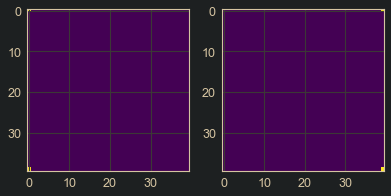

In [76]:
#GRID
n = m = 5*8
h=1/(n-1)
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,n))
BC = "Neumann"

#DISTRIBUTIONS
rho = np.zeros((n,n))
rho[0,0] = 1
rho[n-1,0] = 1
# Final Distribution
sigma = np.zeros((n,n))
sigma[n-1,n-1] = 1
sigma[0,n-1] = 1
f = sigma.flatten()-rho.flatten()

#VARIABLES
Gc=np.ones((n,m))
lam = np.ones((n,m)).flatten()
lam_diag = np.diag(np.append(lam,lam))
lpd = lam_diag.copy()

#DIFFERENCE OPERATORS
Dx = D2xFE(n,m, bc = BC, matrix=True)
Dy = D2yFE(n,m, bc = BC, matrix=True)
Div = np.hstack((Dx.T,Dy.T))
Grad = np.vstack((Dx,Dy))


plt.subplot(121)
plt.imshow(rho[::-1])
plt.subplot(122)
plt.imshow(sigma[::-1])


In [77]:
#FIRST STEP
u = cp.Variable(n*n*2)
prob = cp.Problem(cp.Minimize(cp.sum_squares(Div@lam_diag@u-f)))
prob.solve()
u = u.value.reshape(2,n*n)

#SCALE LAMBDA
norm = np.array([np.linalg.norm(u_) for u_ in u.T])
lam = norm
lam_p=lam
lam_diag = np.diag(np.append(lam,lam))

#SECOND STEP
A = (lam_diag@Grad)
phi = cp.Variable(n*n)
prob = cp.Problem(cp.Minimize(cp.sum_squares(A@phi-u.reshape(2*n*n))))
prob.solve()
phi = phi.value.reshape(n,n)
Gphi = (Grad@phi.reshape(n*n)).reshape(2,n*n)

norm = np.array([np.linalg.norm(gphi) for gphi in Gphi.T])
lam = norm.reshape(n,m)

# lam = Sharpen(lam, max=1.2)
lam = HarmAvg(lam)
lam_diag = np.diag(np.append(lam,lam))
lpd = lam_diag.copy()

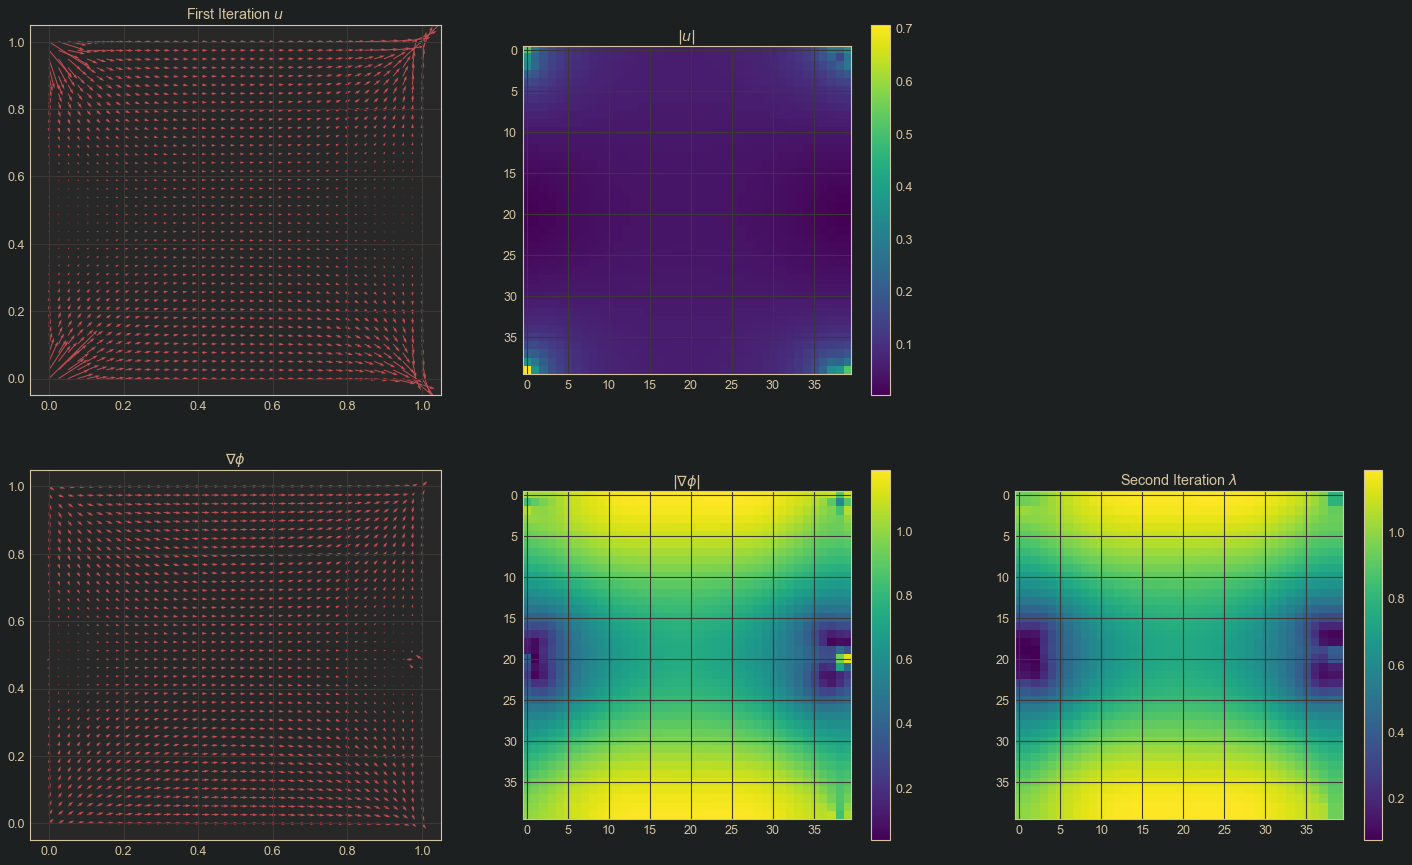

In [78]:
#PLOTTING
plt.figure(figsize=(25,15))
plt.subplot(231)
plt.quiver(xx,yy,u[0],u[1], color='r')
plt.title('First Iteration $u$')
plt.subplot(232)
plt.title('$|u|$')
plt.imshow(lam_p.reshape(n,m)[::-1])
plt.colorbar()
plt.subplot(234)
plt.title('$\\nabla\\phi$')
plt.quiver(xx,yy,Gphi[0], Gphi[1],color='r')
plt.subplot(235)
plt.title('$|\\nabla \\phi|$')
plt.imshow(norm.reshape(n,m)[::-1])
plt.colorbar()
plt.subplot(236)
plt.title('Second Iteration $\\lambda$')
plt.imshow(lam[::-1])
plt.colorbar()
plt.show()


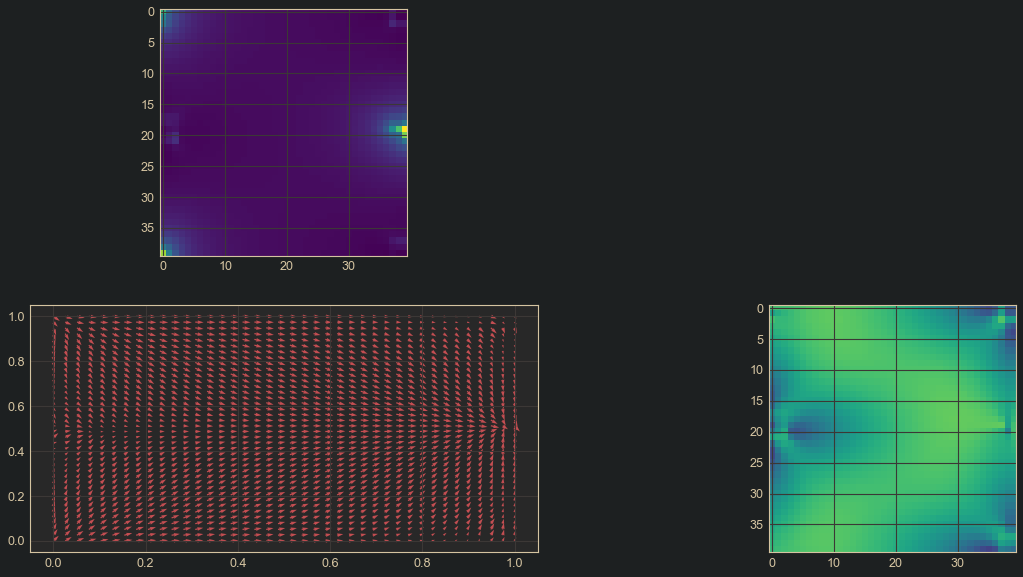

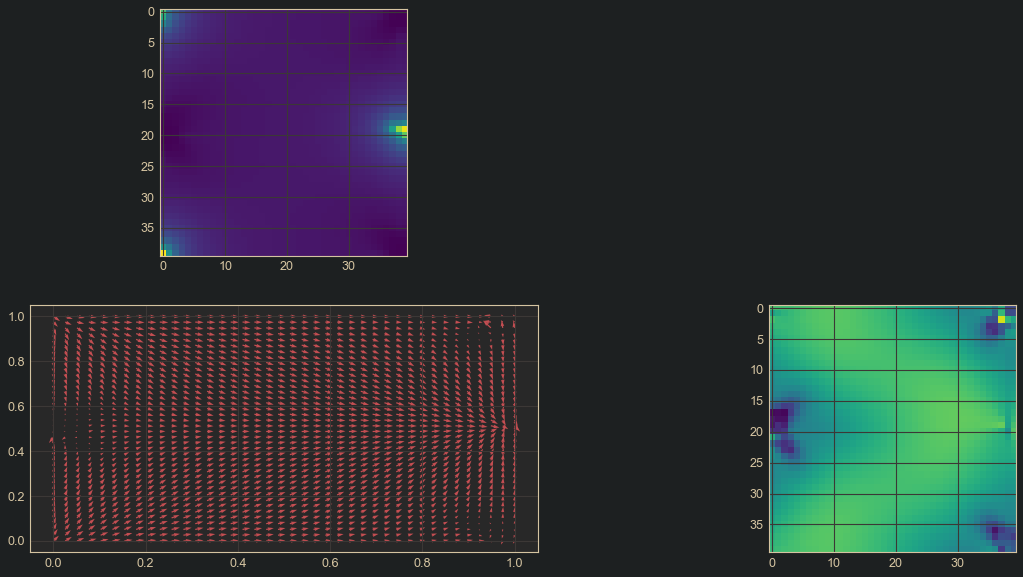

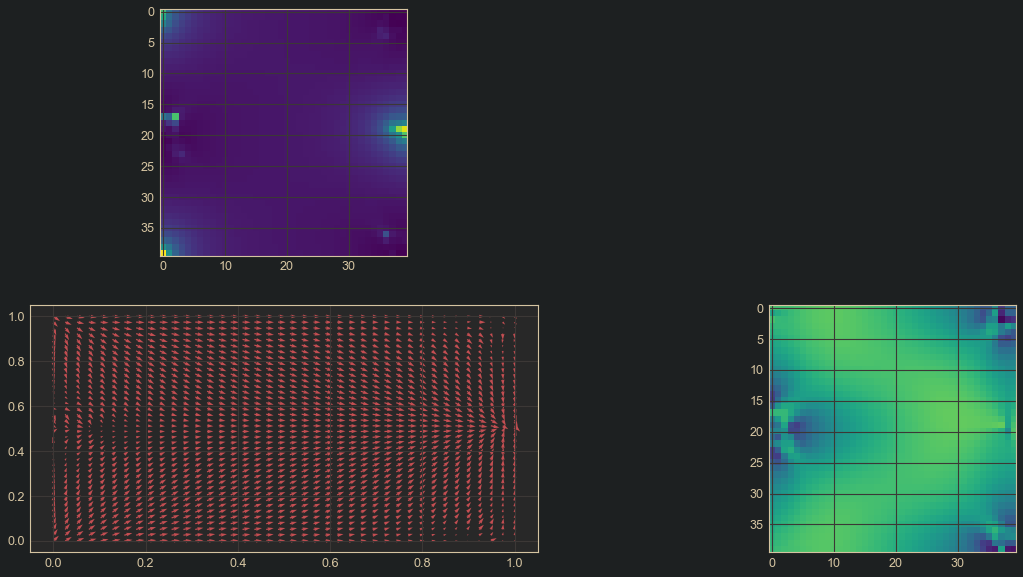

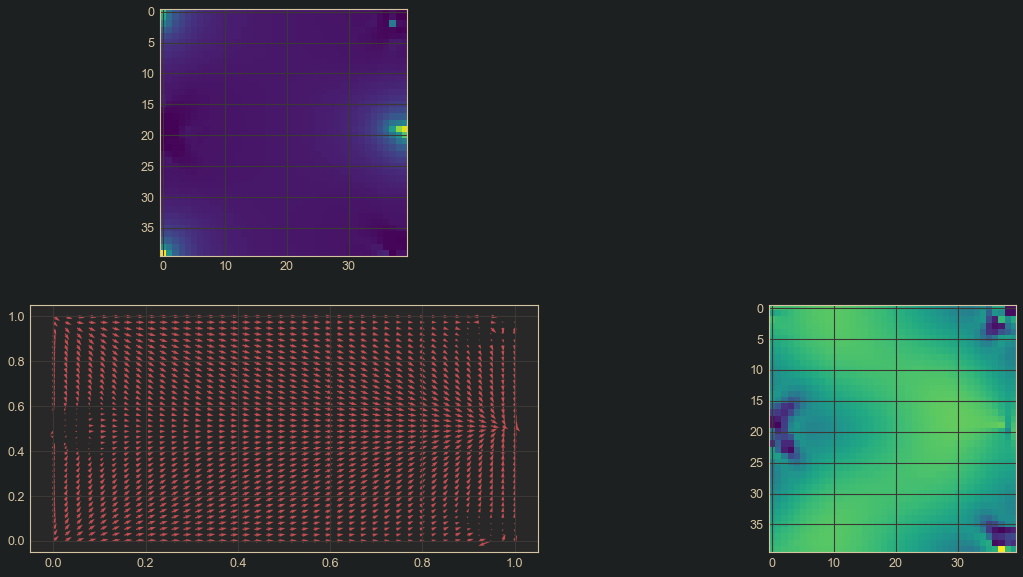

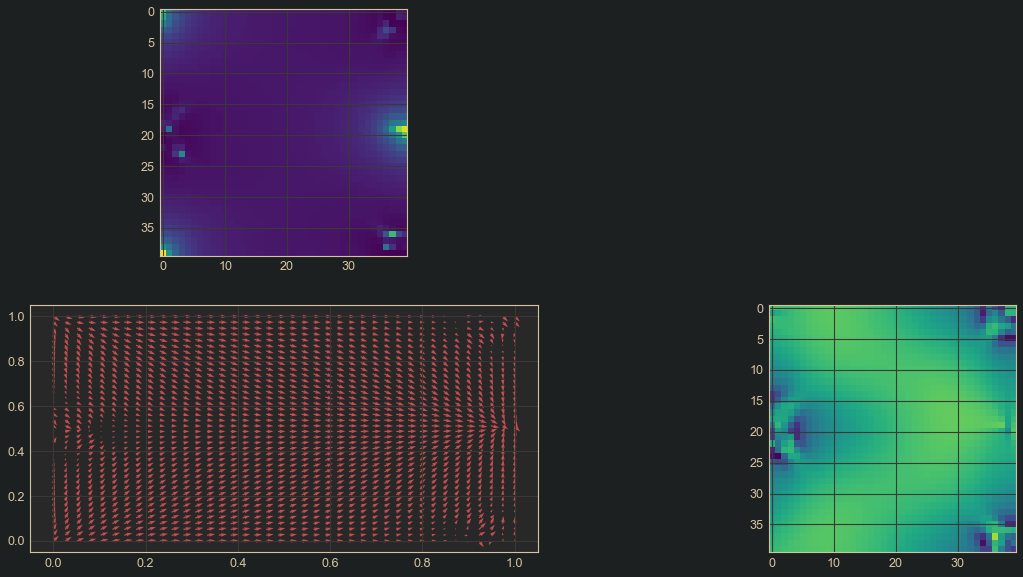

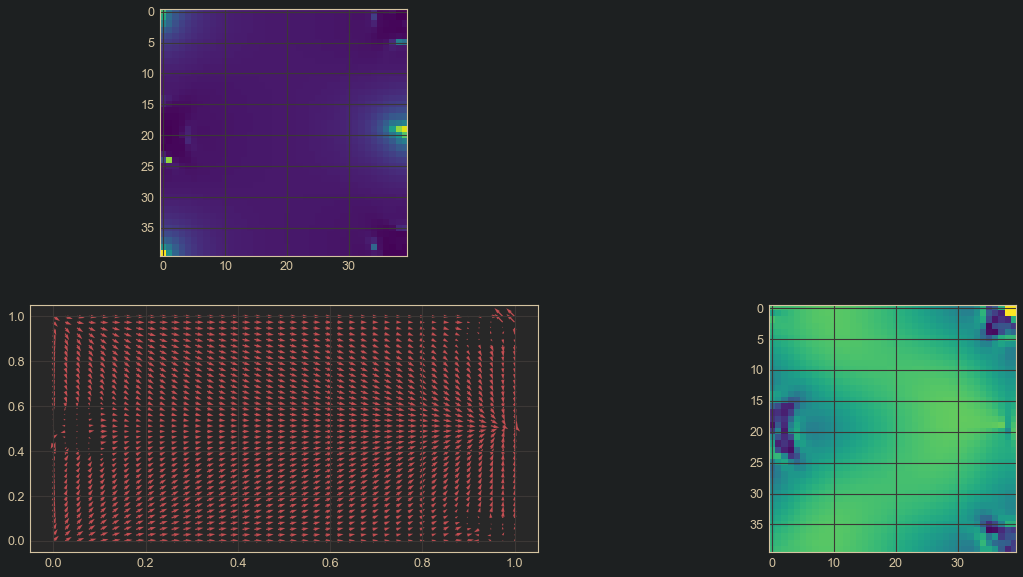

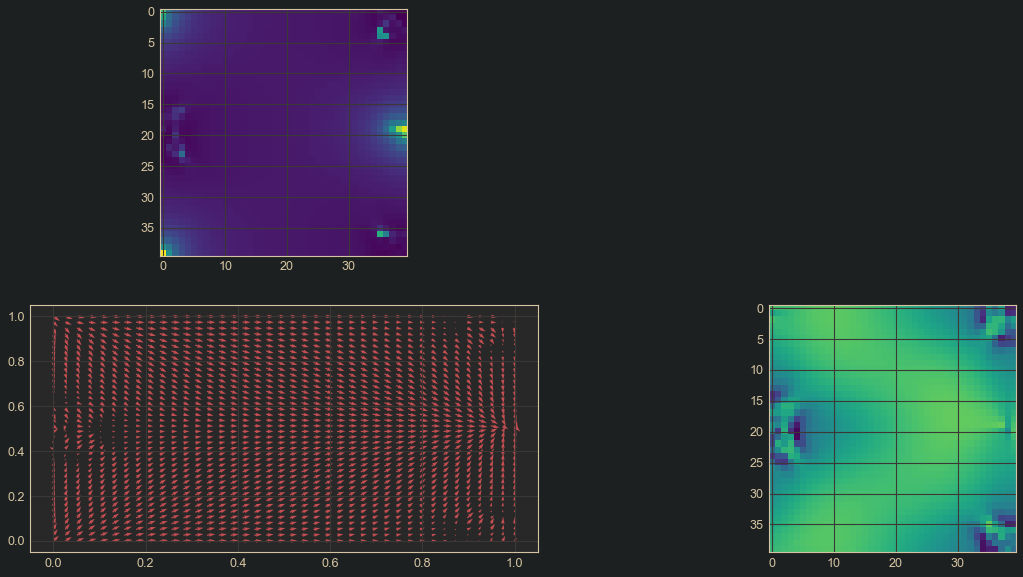

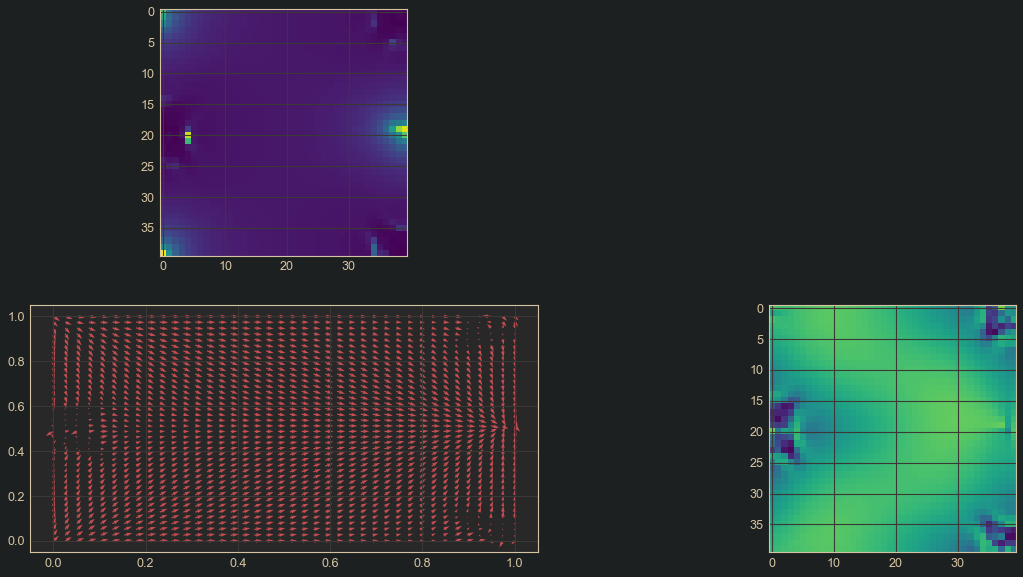

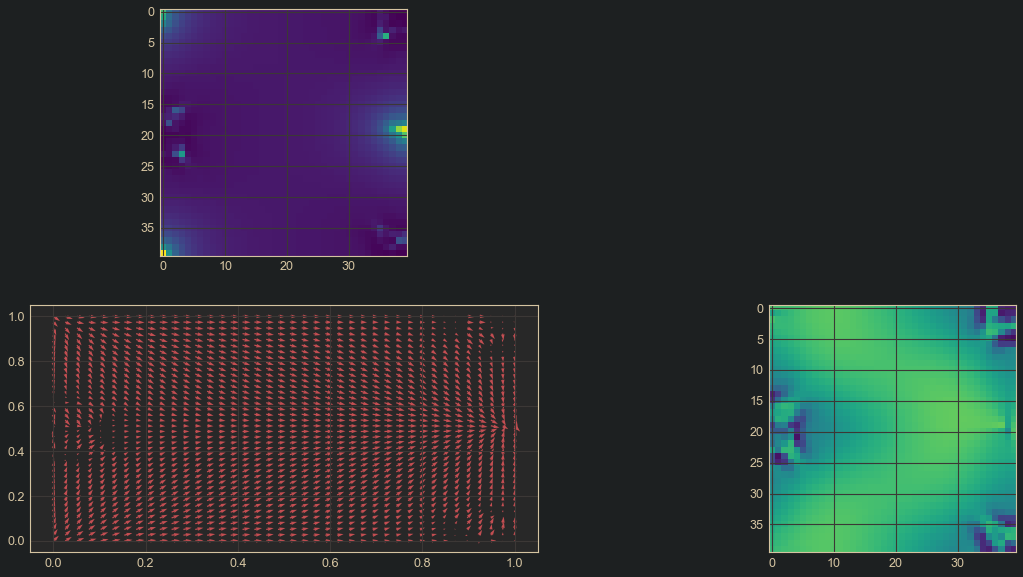

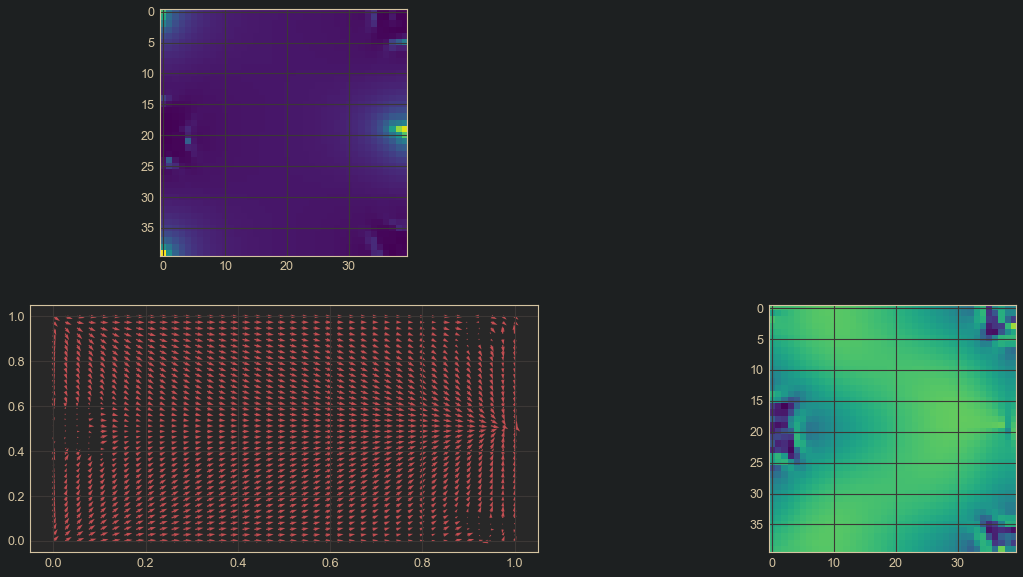

In [72]:
for i in range(10):
    #FIRST STEP
    u = cp.Variable(n*n*2)
    prob = cp.Problem(cp.Minimize(cp.sum_squares(Div@lam_diag@u-f)))
    prob.solve()
    u = u.value.reshape(2,n*n)

    #SCALE LAMBDA
    norm = np.array([np.linalg.norm(u_) for u_ in u.T])
    lam = norm
    plt.figure(figsize=(20,10))
    lam_p=lam
    plt.subplot(221)
    plt.imshow(lam_p.reshape(n,m)[::-1])
    lam_diag = np.diag(np.append(lam,lam))

    #SECOND STEP
    A = (lam_diag@Grad)
    phi = cp.Variable(n*n)
    prob = cp.Problem(cp.Minimize(cp.sum_squares(A@phi-u.reshape(2*n*n))))
    prob.solve()
    phi = phi.value.reshape(n,n)
    Gphi = (Grad@phi.reshape(n*n)).reshape(2,n*n)
    plt.subplot(223)
    plt.quiver(xx,yy,Gphi[0], Gphi[1],color='r')



    norm = np.array([np.linalg.norm(gphi) for gphi in Gphi.T])
    plt.subplot(224)
    plt.imshow(norm.reshape(n,m)[::-1],  vmin=0, vmax=1.5)
    plt.show()
    lam = norm.reshape(n,m)

    # lam = Sharpen(lam, max=2)
    #lam = HarmAvg(lam)
    lam_diag = np.diag(np.append(lam,lam))
    lpd = lam_diag.copy()


    #PLOTTING
    # plt.figure(figsize=(15,10))
    # plt.subplot(231)
    # plt.quiver(xx,yy,u[0],u[1], color='r')
    # plt.title('First Iteration $\\lambda_t$')
    # plt.subplot(232)
    # plt.title('First Iteration $\\lambda$')
    # plt.imshow(lam_p.reshape(n,m)[::-1])
    # plt.colorbar()
    # plt.subplot(234)
    # plt.title('$\\nabla\\phi$')
    # plt.quiver(xx,yy,Gphi[0], Gphi[1],color='r')
    # plt.subplot(235)
    # plt.title('$|\\nabla \\phi|$')
    # plt.imshow(norm.reshape(n,m)[::-1])
    # plt.colorbar()
    # plt.subplot(236)
    # plt.title('Second Iteration $\\lambda$')
    # plt.imshow(lam[::-1], vmin=0, vmax=1.5)
    # plt.colorbar()
    # plt.show()

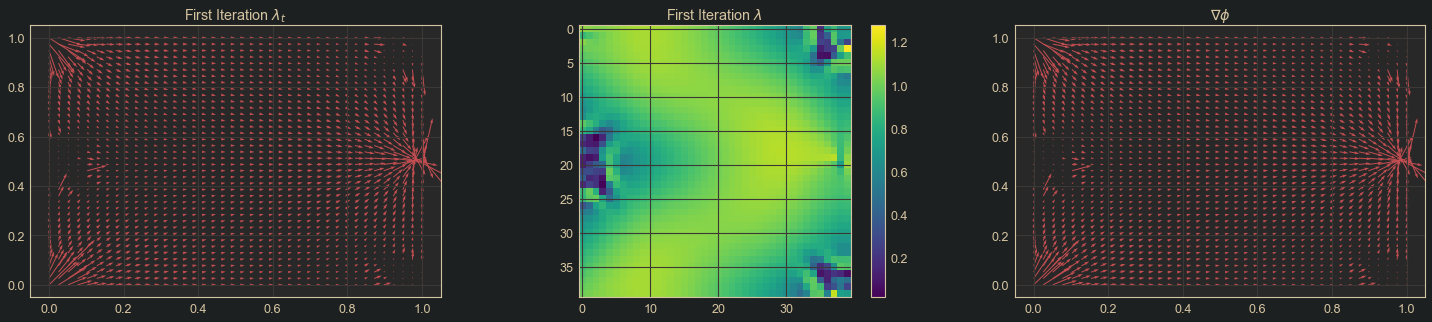

In [73]:
#PLOTTING
plt.figure(figsize=(25,5))
plt.subplot(131)
plt.quiver(xx,yy,u[0],u[1], color='r')
plt.title('First Iteration $\\lambda_t$')
plt.subplot(132)
plt.title('First Iteration $\\lambda$')
plt.imshow(lam[::-1])
plt.colorbar()
plt.subplot(133)
plt.title('$\\nabla\\phi$')
plt.quiver(xx,yy,u[0], u[1],color='r')
plt.show()


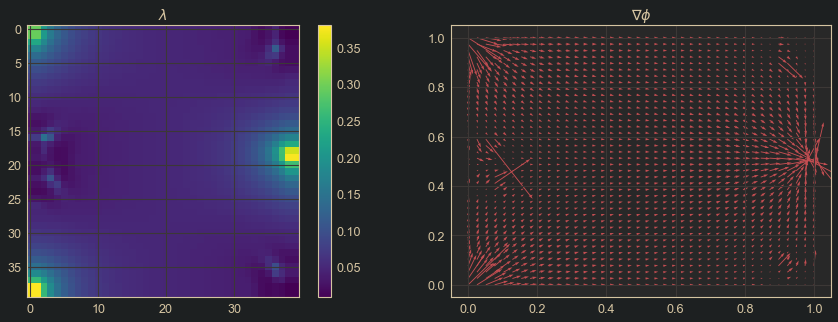

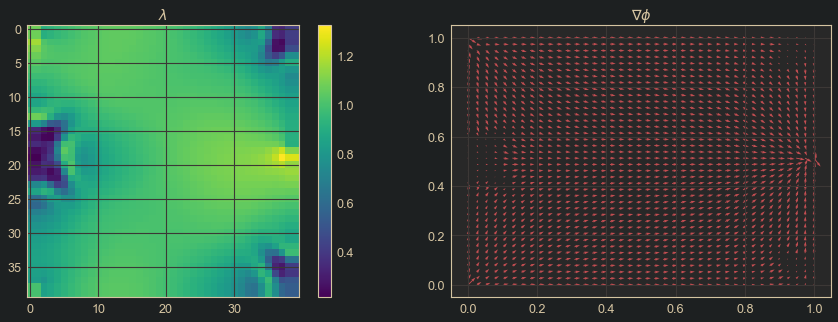

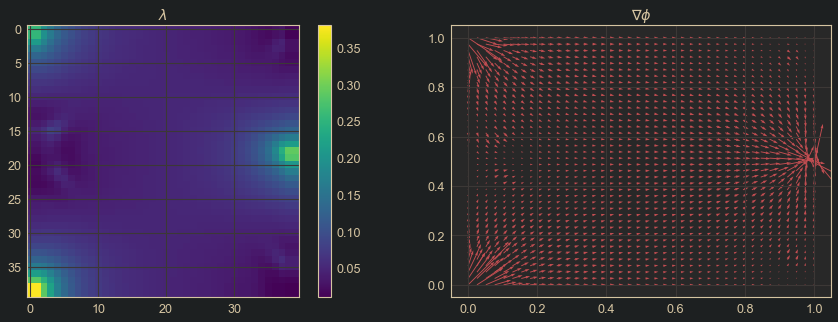

In [74]:
for i in range(3):
    #FIRST STEP
    u = cp.Variable(n*n*2)
    prob = cp.Problem(cp.Minimize(cp.sum_squares(Div@lam_diag@u-f)))
    prob.solve()
    u = u.value.reshape(2,n*n)

    #SCALE LAMBDA
    norm = np.array([np.linalg.norm(u_) for u_ in u.T])
    lam = HarmAvg(norm.reshape(n,m))
    lam_p=lam
    lam_diag = np.diag(np.append(lam,lam))

    #PLOTTING
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('$\\lambda$')
    plt.imshow(lam_p[::-1])
    plt.colorbar()
    plt.subplot(122)
    plt.title('$\\nabla\\phi$')
    plt.quiver(xx,yy,u[0], u[1],color='r')
    plt.show()


## Double Iteration

NameError: name 'lam_p' is not defined

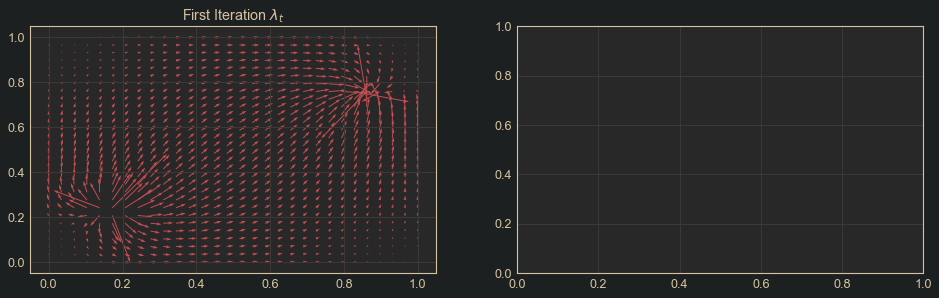

In [75]:
#GRID
n = m = 5*6
h=1/(n-1)
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,n))
BC = "Neumann"

#DISTRIBUTIONS
rho = np.zeros((n,n))
rho[n//4,n//6] = 1
# Final Distribution
sigma = np.zeros((n,n))
sigma[3*n//4,5*n//6] = 1

#VARIABLES
Gc=np.ones((n,m))

#SOLVE
lam = lambdaHA(xx, yy, rho, sigma, Gc, diff='ForwardEuler', vis=True )
lam = lambdaHA(xx, yy, rho, sigma, Gc, lam = lam, diff='ForwardEuler', vis=True )

*Note:* Iterations do not converge because the solution in the first step does not change.

## FDM One Step: Variable Poisson

### Single Iteration

In [ ]:
n = m = 5*6
h=1/(n-1)
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,n))
# Initial Distribution
rho = np.zeros((n,n))
rho[m//2,n//6] = 1
# Final Distribution
sigma = np.zeros((n,n))
sigma[m // 2,5*n // 6] = 1
#Gradient C
lam = np.ones((m-1)*(n-1))
Gc = np.ones(m*n)

plt.subplot(121)
plt.imshow(rho[::-1])
plt.subplot(122)
plt.imshow(sigma[::-1])

In [ ]:
f = (sigma[1:-1,1:-1]-rho[1:-1,1:-1]).flatten()
phi = cp.Variable((n-2)*(m-2))
P = VP2A(n-1,m-1,lam)
prob = cp.Problem(cp.Minimize(cp.sum_squares(P@phi+f)))
prob.solve()


In [ ]:
#Extend PHI
phi = phi.value.reshape((n-2,m-2))
phi = np.vstack((phi[0,:],phi,phi[-1,:]))
phi = np.vstack((phi[:,0], phi.T, phi[:,-1])).T

In [ ]:
Dx = D2xFE(n,m, "Mixed",matrix=True)
Dy = D2yFE(n,m, "Mixed",matrix=True)
G = np.array([Dx,Dy])/h
Gphi = G@phi.flatten()
plt.quiver(xx,yy,Gphi[0],Gphi[1], color='r', scale = n)

### Iterations

In [ ]:
"""
itrs = 10

# GENERATE GRID
n = m = 5*6
h=1/(n-1)
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,n))

# GENERATE DISTRIBUTIONS
rho = np.zeros((n,n))
rho[m//2,n//6] = 1
sigma = np.zeros((n,n))
sigma[m // 2,5*n // 6] = 1
f = (sigma[1:-1,1:-1]-rho[1:-1,1:-1]).flatten()

# GENERATE KAPPA VARIABLES
lam = np.ones((n-1)*(m-1))
Gc = np.ones(m*n)

# GENERATE FDMs
Dx = D2xFE(n,m, "Neumann",matrix=True)
Dy = D2yFE(n,m, "Neumann",matrix=True)
Grad = np.array([Dx,Dy])/h


for i in range(itrs):
    # UPDATE LAM AFTER FIRST PASS
    if i > 0:
        for i,_norm in enumerate(norm[:-1,:-1].flatten()):
            if _norm<1:
                lam[i]=.1
            else:
                lam[i]=1

    #FIND PHI USING LAM
    phi = cp.Variable((n-2)*(m-2))
    P = VP2(n-1,m-1,lam)
    prob = cp.Problem(cp.Minimize(cp.sum_squares(P@phi+f)))
    prob.solve()

    #EXTEND PHI
    phi = phi.value.reshape((n-2,m-2))
    phi = np.vstack((phi[0,:],phi,phi[-1,:]))
    phi = np.vstack((phi[:,0], phi.T, phi[:,-1])).T

    #GRADIENT PHI
    Gphi = G@phi.flatten()
    norm = np.array([np.linalg.norm(gphi) for gphi in Gphi.T]).reshape(n,m)
    mean = np.mean(norm)

    #PLOTS
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.imshow(lam.reshape((n-1,m-1)),vmin=0,vmax=1)
    plt.title('$\lambda$')
    plt.subplot(142)
    plt.imshow(phi.reshape((n,m)))
    plt.title('$\phi$')
    plt.subplot(143)
    plt.imshow(norm,vmin=0,vmax=1)
    plt.title('Norm')
    plt.subplot(144)
    plt.title('$\\nabla\phi$')
    plt.quiver(xx,yy,Gphi[0],Gphi[1], color='r', scale = n)
    """

## Three Step: Standard and VP

### Standard Step

In [ ]:
#GRID
n = m = 5*6
h=1/(n-1)
dt=1
xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,n))
BC = "Neumann"

#DISTRIBUTIONS
rho = np.zeros((n,n))
rho[n//4,n//6] = 1
# Final Distribution
sigma = np.zeros((n,n))
sigma[3*n//4,5*n//6] = 1
f = sigma.flatten()-rho.flatten()

#VARIABLES
Gc=np.ones((n,m))

#DIFFERENCE OPERATORS
Dx = D2xFE(n,m, bc = BC, matrix=True)
Dy = D2yFE(n,m, bc = BC, matrix=True)
Div = np.hstack((Dx.T,Dy.T))
Grad = np.vstack((Dx,Dy))


plt.subplot(121)
plt.imshow(rho[::-1])
plt.subplot(122)
plt.imshow(sigma[::-1])


In [ ]:
#FIRST STEP
lam_t = cp.Variable(n*n*2)
prob = cp.Problem(cp.Minimize(cp.sum_squares(Div@lam_t-f)))
prob.solve()
lam_t = lam_t.value.reshape(2,n*n)

#SCALE LAMBDA
norm = np.array([np.linalg.norm(_lam_t) for _lam_t in lam_t.T])
lam = norm
lam_p=lam
lam = np.diag(np.append(lam,lam))

#SECOND STEP
A = (lam@Grad)
phi = cp.Variable(n*n)
prob = cp.Problem(cp.Minimize(cp.sum_squares(A@phi-lam_t.reshape(2*n*n))))
prob.solve()
phi = phi.value.reshape(n,n)
Gphi = (Grad@phi.reshape(n*n)).reshape(2,n*n)

norm = np.array([np.linalg.norm(gphi) for gphi in Gphi.T])

#PLOTTING
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.quiver(xx,yy,lam_t[0],lam_t[1], color='r')
plt.title('First Iteration $\\lambda_t$')
plt.subplot(222)
plt.imshow(lam_p.reshape(n,n)[::-1])
plt.title('First Iteration $\\lambda$')
plt.colorbar()
plt.subplot(223)
plt.title('$\\phi$')
plt.imshow(phi[::-1])
plt.subplot(224)
plt.title('$\\nabla\\phi$')
plt.quiver(xx,yy,Gphi[0], Gphi[1],color='r')
plt.show()

plt.imshow(norm.reshape((n,n))[::-1])
plt.colorbar()

In [ ]:
lam = norm - 1*np.ones(len(norm))
lam = lam.clip(min=1e-5)
lam_p = lam

plt.imshow(lam.reshape((n,m))[::-1]+rho[::-1]+sigma[::-1])
plt.colorbar()
lam = lam.reshape((n,m))[1:,1:].flatten()

### Variable Poisson Step

In [ ]:
f = (sigma[1:-1,1:-1]-rho[1:-1,1:-1]).flatten()
phi = cp.Variable((n-2)*(m-2))
P = VP2A(n-1,m-1,lam)
prob = cp.Problem(cp.Minimize(cp.sum_squares(P@phi-f)))
prob.solve()

#Extend PHI
phi = phi.value.reshape((n-2,m-2))
phi = np.vstack((phi[0,:],phi,phi[-1,:]))
phi = np.vstack((phi[:,0], phi.T, phi[:,-1])).T

Dx = D2xFE(n,m, "Mixed",matrix=True)
Dy = D2yFE(n,m, "Mixed",matrix=True)
G = np.array([Dx,Dy])/h
Gphi = G@phi.flatten()
plt.quiver(xx,yy,Gphi[0],Gphi[1], color='r', scale = .01)